# Clustering Model

## Libraries

In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import random

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE,MDS
from sklearn.cluster import AgglomerativeClustering,KMeans
from sklearn.mixture import GaussianMixture

from scipy.stats import kruskal

from sklearn.feature_selection import SelectKBest

import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [ ]:
csv = '2018_Yellow_Taxi_Trip_Data.csv'

fields = ['passenger_count', 'trip_distance', 'tip_amount',
          'total_amount', 'PULocationID', 'DOLocationID']

In [ ]:
temp =dd.read_csv(csv,
                 usecols=fields,
                 dtype={'passenger_count':'int8', 'trip_distance':'float32', 
                        'total_amount':'float32', 'PULocationID': 'int16',
                        'DOLocationID':'int16', 'tip_amount': 'float16'})

In [ ]:
temp.describe(percentiles=(0.01,0.99)).compute().T[['min','1%','99%','max']]

,min,1%,99%,max
passenger_count,-64.000000,1.0,6.000000,96.00000
trip_distance,0.000000,0.2,19.629999,189483.84375
PULocationID,1.000000,13.0,264.000000,265.00000
DOLocationID,1.000000,13.0,264.000000,265.00000
tip_amount,-322.500000,0.0,13.046875,946.00000
total_amount,-800.299988,4.8,75.669998,907071.06250


### Vamos a predecir el numero de pasajeros.
Tiramos los que tengan 0, 7,8 y 9 pasajeros

In [ ]:
temp = temp[temp['passenger_count'] > 0]
temp = temp[temp['passenger_count'] < 7]
temp = temp[temp['trip_distance'] > 0]
temp = temp[temp['total_amount'] > 0]

In [ ]:
df = temp.sample(frac=0.000008).compute()

In [ ]:
df.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,tip_amount,total_amount
count,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000
mean,1.592638,2.939276,161.150920,157.980368,1.917969,16.325069
std,1.205412,3.818235,67.278825,71.961135,2.480469,13.937790
min,1.000000,0.070000,4.000000,1.000000,0.000000,3.300000
25%,1.000000,0.920000,113.000000,107.000000,0.000000,8.300000
50%,1.000000,1.570000,162.000000,162.000000,1.450195,11.800000
75%,2.000000,3.110000,233.000000,233.000000,2.455078,18.299999
max,6.000000,34.900002,264.000000,265.000000,25.546875,153.350006


In [ ]:
df.describe(percentiles=[0.001, 0.01, 0.99]).T[['0.1%', '1%', '99%']]

,0.1%,1%,99%
passenger_count,1.00000,1.0,6.000000
trip_distance,0.09442,0.3,18.647400
PULocationID,6.44200,13.0,264.000000
DOLocationID,1.00000,7.0,264.000000
tip_amount,0.00000,0.0,11.703125
total_amount,3.70700,4.8,69.197600


## Visualization

In [ ]:
varc = [v for v in df.columns if v != "passenger_count"]
varc

['trip_distance', 'PULocationID', 'DOLocationID', 'tip_amount', 'total_amount']

In [ ]:
X = df[varc].copy()

### PCA

In [ ]:
sc = StandardScaler()
sc.fit(X)
Xs = pd.DataFrame(sc.transform(X),columns=varc)
pca = PCA(n_components=2)
pca.fit(Xs)
pca.explained_variance_ratio_.cumsum()

array([0.5179963 , 0.74349976], dtype=float32)

In [ ]:
Xp = pd.DataFrame(pca.transform(Xs),columns=['d1','d2'])

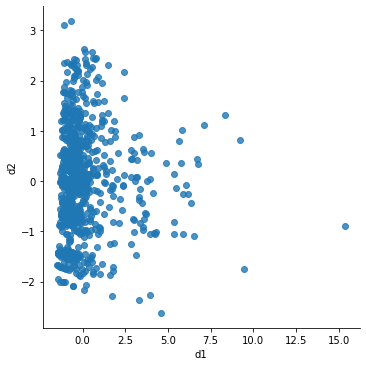

In [ ]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False)

### MDS

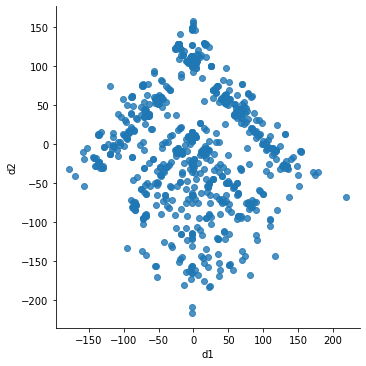

In [ ]:
mds = MDS(n_components=2,n_jobs=-1)
Xm = pd.DataFrame(mds.fit_transform(X),columns=['d1','d2'])
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False)

### T-SNE

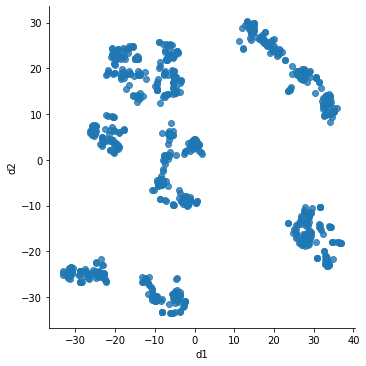

In [ ]:
tsne = TSNE(n_components=2,n_jobs=-1)
Xt = pd.DataFrame(tsne.fit_transform(X),columns=['d1','d2'])
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False)

## Exploratory Analysis

In [ ]:
X.describe(percentiles=np.arange(0,1,0.1))

,trip_distance,PULocationID,DOLocationID,tip_amount,total_amount
count,815.000000,815.000000,815.000000,815.000000,815.000000
mean,2.939276,161.150920,157.980368,1.917969,16.325069
std,3.818235,67.278825,71.961135,2.480469,13.937790
min,0.070000,4.000000,1.000000,0.000000,3.300000
0%,0.070000,4.000000,1.000000,0.000000,3.300000
10%,0.600000,68.000000,48.000000,0.000000,6.368000
20%,0.818000,100.000000,87.000000,0.000000,7.850000
30%,1.040000,132.000000,125.000000,0.000000,8.800000
40%,1.296000,141.000000,142.000000,1.000000,10.300000
50%,1.570000,162.000000,162.000000,1.450195,11.800000


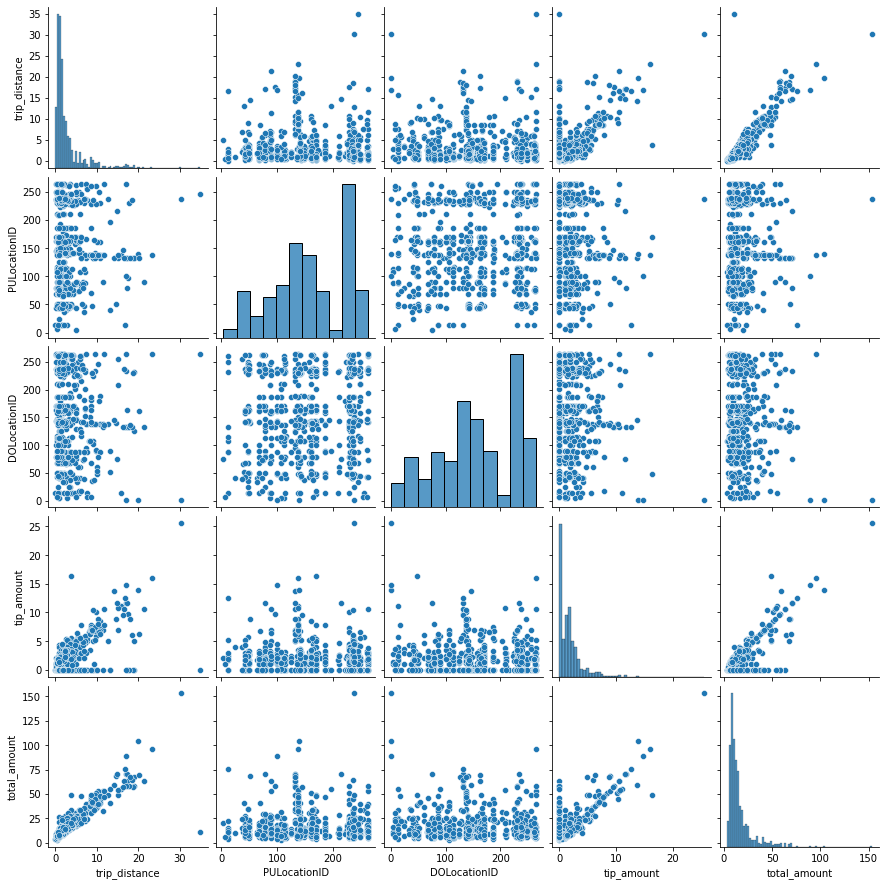

In [ ]:
sns.pairplot(X)

In [ ]:
X.corr()

,trip_distance,PULocationID,DOLocationID,tip_amount,total_amount
trip_distance,1.000000,-0.034582,-0.089966,0.644051,0.907124
PULocationID,-0.034582,1.000000,0.141475,-0.020398,-0.039812
DOLocationID,-0.089966,0.141475,1.000000,-0.061298,-0.112205
tip_amount,0.644051,-0.020398,-0.061298,1.000000,0.799711
total_amount,0.907124,-0.039812,-0.112205,0.799711,1.000000


### # of Clusters

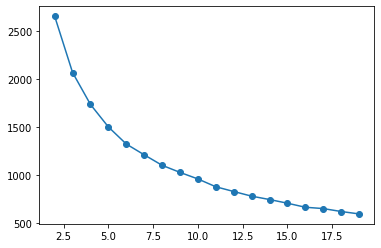

In [ ]:
l = []
for k in range(2,20):
    cl = KMeans(n_clusters=k)
    cl.fit(Xs)
    l.append(cl.inertia_)
plt.plot(range(2,20),l,marker='o')

In [ ]:
k = 7

In [ ]:
varc = X.columns.tolist()
varc

['trip_distance', 'PULocationID', 'DOLocationID', 'tip_amount', 'total_amount']

## Modelo no supervisado (Aglomerativo)

0    0.052761
1    0.360736
2    0.020859
3    0.134969
4    0.139877
5    0.160736
6    0.130061
Name: agg, dtype: float64

<AxesSubplot:ylabel='agg'>

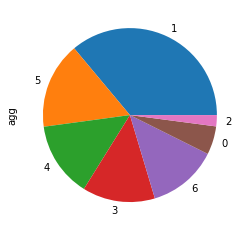

In [ ]:
cl = 'agg'
agg = AgglomerativeClustering(n_clusters=k)
X[cl]=Xs[cl]=Xm[cl]=Xt[cl]=Xp[cl]=df[cl] = agg.fit_predict(Xs[varc])
display(df[cl].value_counts(True).sort_index())
df[cl].value_counts().plot(kind='pie')

## K-Means

0    0.166871
1    0.195092
2    0.285890
3    0.022086
4    0.072393
5    0.236810
6    0.020859
Name: kme, dtype: float64

<AxesSubplot:ylabel='kme'>

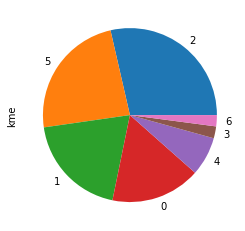

In [ ]:
cl = 'kme'
agg = KMeans(n_clusters=k)
X[cl]=Xs[cl]=Xm[cl]=Xt[cl]=Xp[cl]=df[cl] = agg.fit_predict(Xs[varc])
display(df[cl].value_counts(True).sort_index())
df[cl].value_counts().plot(kind='pie')

## Gaussian Mixture

0    0.159509
1    0.050307
2    0.269939
3    0.132515
4    0.169325
5    0.107975
6    0.110429
Name: gau, dtype: float64

<AxesSubplot:ylabel='gau'>

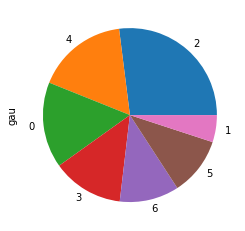

In [ ]:
cl = 'gau'
agg = GaussianMixture(n_components=k)
X[cl]=Xs[cl]=Xm[cl]=Xt[cl]=Xp[cl]=df[cl] = agg.fit_predict(Xs[varc])
display(df[cl].value_counts(True).sort_index())
df[cl].value_counts().plot(kind='pie')

## 2D Visualization

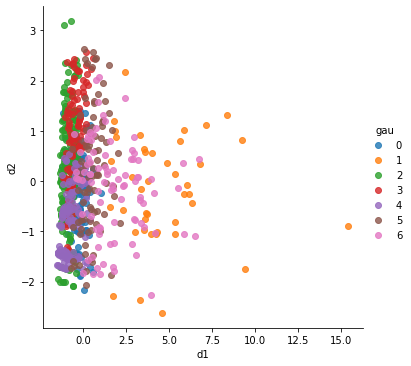

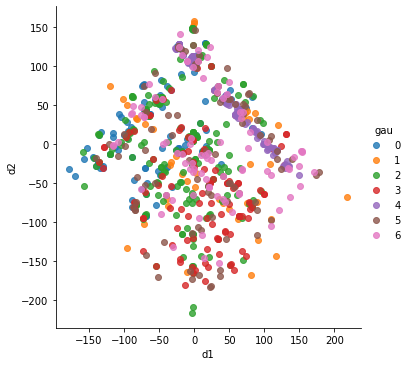

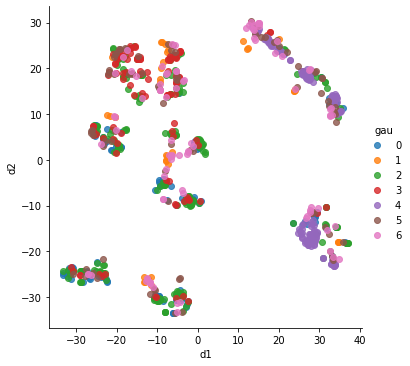

In [ ]:
sns.lmplot(data=Xp,x='d1',y='d2',fit_reg=False,hue='gau')
sns.lmplot(data=Xm,x='d1',y='d2',fit_reg=False,hue='gau')
sns.lmplot(data=Xt,x='d1',y='d2',fit_reg=False,hue='gau')

## Perfilamiento

$p-value<\alpha$ Son diferentes y por tanto la variable sirve para perfilar


In [ ]:
pd.DataFrame(map(lambda v:(v,kruskal(*[d[v].tolist() for _,d in df.groupby('gau')]).pvalue),
       varc),columns=['variable','p-value'])

,variable,p-value
0,trip_distance,2.843500e-109
1,PULocationID,1.830534e-42
2,DOLocationID,1.184611e-25
3,tip_amount,3.332350e-60
4,total_amount,1.057493e-129


In [ ]:
sk = SelectKBest(k='all')
sk.fit(X[varc],X['gau'])

SelectKBest(k='all')

In [ ]:
best = [v for v,x in zip(varc,sk.get_support()) if x]
best 

['trip_distance', 'PULocationID', 'DOLocationID', 'tip_amount', 'total_amount']

## Examples

In [ ]:
k = 5
cl = 2
for id in df.loc[df['gau']==cl].sample(k).DOLocationID:
    print(id)

140
142
246
224
238


In [ ]:
i = 5
cluster = 4
for id in df.loc[df['gau']==cluster].sample(i).trip_distance:
    print(id)

0.699999988079071
1.2999999523162842
0.4699999988079071
0.6000000238418579
0.49000000953674316


# Persistencia

In [ ]:
import pickle
pickle.dump((sc, agg),open('gaussian cluster_midterm.pkl','wb'))